## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA 

Fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Tue Apr  1 23:05:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.75                 Driver Version: 566.24         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
|  0%   39C    P8             10W /  450W |   23242MiB /  24564MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

In [4]:
ls -l

total 19156
-rw-r--r-- 1 root root    16179 Mar 28 03:15  Comicgen_v2_SDXL_finetuning_Dreambooth.ipynb
-rw-r--r-- 1 root root  3208363 Mar 27 22:29  Comicgen_v3_SDXL_finetuning_Dreambooth.ipynb
-rwxrwxrwx 1 root root  1487656 Mar 28 21:34  Comicgen_v4_SDXL_DreamBooth_LoRA_v0.1.ipynb*
-rw-r--r-- 1 root root  1489534 Mar 28 21:37  Comicgen_v4_SDXL_DreamBooth_LoRA_v0.2.ipynb
drwxrwxrwx 1 root root     4096 Mar 28 21:36 'Output images'/
-rw-r--r-- 1 root root 13310503 Mar 28 21:03 'SDXL_Dreambooth Lora Inference.ipynb'
-rw-r--r-- 1 root root     6878 Mar 27 23:11  Untitled.ipynb
drwxr-xr-x 1 root root     4096 Mar 28 02:20  content/
drwxrwxrwx 1 root root     4096 Mar 28 00:27  custom_dataset/
drwxr-xr-x 1 root root     4096 Mar 28 21:36  diffusers/
-rwxrwxrwx 1 root root       87 Mar 27 21:55  requirements.txt*
drwxrwxrwx 1 root root     4096 Mar 27 23:05  sdxl-dreambooth-finetune-master/
-rw-r--r-- 1 root root    84961 Mar 27 22:01  train_dreambooth_lora_sdxl.py


Download diffusers SDXL DreamBooth training script.

## Auto-generate caption.json based on filenames

In [5]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

/usr/bin/sh: 1: wget: not found


## Dataset 

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.



**Option 1:** upload example images from your local files:

In [84]:
import os


In [6]:
import os
%cd content

if os.path.exists("content/custom_dataset"):
    print("Removing existing custom_dataset folder")
    !rm -rf  "content/custom_dataset"

print("Creating new custom_dataset folder")
!mkdir content
!mkdir  content/custom_dataset
!mkdir  content/custom_dataset/frog
!mkdir  content/custom_dataset/'yarn style'


/app/content
Removing existing custom_dataset folder


/opt/conda/envs/comicgen1/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Creating new custom_dataset folder
mkdir: cannot create directory ‘content’: File exists


In [16]:
import shutil
import os

src = 'custom_dataset/'
dst = 'content/custom_dataset/yarn style'
os.makedirs(dst, exist_ok=True)

for f in os.listdir(src):
    shutil.copy(os.path.join(src, f), dst)

IsADirectoryError: [Errno 21] Is a directory: 'custom_dataset/class_images'

### File path:

##
content/custom_dataset/yarn style

In [26]:
import os
import json

# Folder where your images are stored
dataset_dir = 'content/custom_dataset/yarn style_no caption'
caption_file = os.path.join(dataset_dir, "caption.json")

# Template prompt using 'TOK' as the subject keyword
prompt_template = "{} in yarnstyle art"

# Create captions from filenames
captions = {}

# Loop through files in dataset_dir
for filename in os.listdir(dataset_dir):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        # Remove extension and extra spaces
        name = os.path.splitext(filename)[0].strip()
        name = name.replace("_", " ").replace(",", "").replace("  ", " ")
        
        # Optional: Clean up known phrases
        if name.lower().startswith("a "):
            subject = name[2:].strip()
        else:
            subject = name
        
        # Format the prompt
        prompt = prompt_template.format(subject.lower())
        captions[filename] = prompt

# Save to caption.json
with open(caption_file, "w") as f:
    json.dump(captions, f, indent=4)

print(f"✅ caption.json generated at: {caption_file}")


✅ caption.json generated at: content/custom_dataset/yarn style/caption.json


In [35]:
ls -l content/custom_dataset/'yarn style'/

total 13984
-rwxrwxrwx 1 root root 494568 Mar 27 22:13 'A Mystique and calm woman, yarn art style.png'*
-rw-r--r-- 1 root root 528247 Mar 27 22:13 'A bunch of colorful flowers, yarn art style.png'
-rw-r--r-- 1 root root 529173 Mar 27 22:13 'A castle cake, yarn art style.png'
-rw-r--r-- 1 root root 565777 Mar 27 22:13 'A cat, yarn art style.png'
-rw-r--r-- 1 root root 525801 Mar 27 22:13 'A clown, yarn art style.png'
-rw-r--r-- 1 root root 578497 Mar 27 22:13 'A colorful woman, yarn art style.png'
-rwxrwxrwx 1 root root 469454 Mar 27 22:13 'A cute dog, yarn art style.png'*
-rw-r--r-- 1 root root 636496 Mar 27 22:13 'A dog, yarn art style.png'
-rw-r--r-- 1 root root 400478 Mar 27 22:13 'A planet, yarn art style.png'
-rwxrwxrwx 1 root root 422372 Mar 27 22:13 'A socially awkward potato , yarn art style.png'*
-rwxrwxrwx 1 root root 458794 Mar 27 22:13 'An angry woman screaming JojosoStyle, yarn art style.png'*
-rw-r--r-- 1 root root 540507 Mar 27 22:13 'Castle, yarn art style.png'
-rw-r--r

Preview the images:

In [36]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

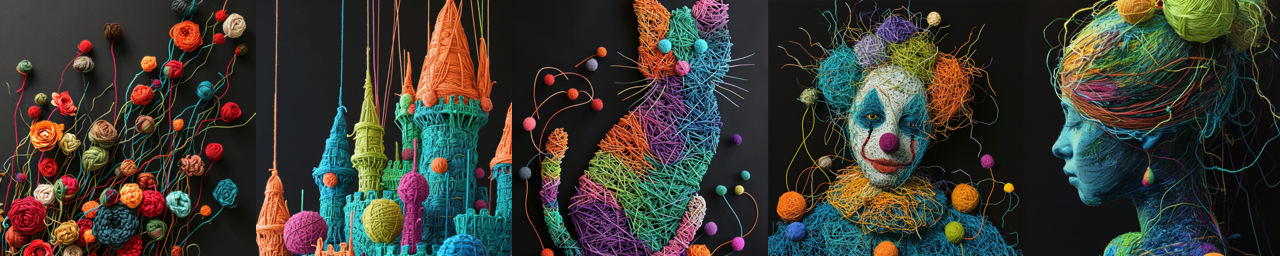

In [40]:
import glob

# change path to display images from your local dir
img_paths = 'content/custom_dataset/yarn style_no caption/*.png'
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [44]:
import json

caption_prefix = "a photo of yarn art style frog, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free some memory:

In [45]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [47]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [48]:
!pip install huggingface_hub
!pip install ipywidgets

In [4]:
from huggingface_hub import login,notebook_login
import tqdm as notebook_tqdm

### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [5]:
from huggingface_hub import notebook_login
notebook_login()


## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [52]:
!pip install datasets -q

In [6]:
import requests

url = "https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py"
response = requests.get(url)
with open("train_dreambooth_lora_sdxl.py", "wb") as f:
    f.write(response.content)
    
print("Script downloaded successfully!")

Script downloaded successfully!


In [54]:
!pip install -q accelerate diffusers transformers peft datasets bitsandbytes

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [7]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir='content/custom_dataset/yarn style_no caption/' \
  --output_dir='content/output/sdxl_dreambooth_lora_yarn_art_v3' \
  --caption_column="prompt" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo in yarnstyle art" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=5000 \
  --checkpointing_steps=717 \
  --seed="0"

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:498: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/01/2025 23:12:02 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'clip_sample_range', 'thresholding', 'rescale_betas_zero_snr', 'dynamic_thresholding_ratio'} was not found in config. Values will be initialized to default values.
{'latents_mean', 'latents_std', 'use_quant_conv', 'use_post_quant_